In [52]:
%load_ext autoreload
%autoreload 2

import os
import re
import math
import glob
from importlib import reload

import tqdm 
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
obj_dataset = dataset.replay_mapping_from_cache(500)

Loading objects from .data/: 100%|██████████| 500/500 [00:12<00:00, 38.67it/s]


In [54]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
495,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
496,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
497,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
498,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [81]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

Turning replays into time series data: 100%|██████████| 500/500 [00:16<00:00, 29.60it/s]


In [82]:
input = input_data
output = output_data

In [83]:
input[0:500]

x         y  time_until_click  is_slider  is_spinner  \
chunk frame                                                                
0     0     -0.355469 -0.500000             0.450        1.0         0.0   
      1     -0.355469 -0.500000             0.426        1.0         0.0   
      2     -0.355469 -0.500000             0.402        1.0         0.0   
      3     -0.355469 -0.500000             0.378        1.0         0.0   
      4     -0.355469 -0.500000             0.354        1.0         0.0   
...               ...       ...               ...        ...         ...   
      495    0.171875 -0.005208             0.000        1.0         0.0   
      496    0.195312  0.033854             0.000        1.0         0.0   
      497    0.207031  0.083333             0.000        1.0         0.0   
      498    0.201172  0.135417             0.000        1.0         0.0   
      499    0.179688  0.179688             0.000        1.0         0.0   

               cs  slider_speed  slider_len  
chunk frame                                  
0     0      0.52      0.845867       0.605  
      1      0.52      0.845867       0.605  
      2      0.52      0.845867       0.605  
      3      0.52      0.845867       0.605  
      4      0.52      0.845867       0.605  
...           ...           ...         ...  
      495    0.52      0.422933       0.345  
      496    0.52      0.422933       0.345  
      497    0.52      0.422933       0.345  
      498    0.52      0.422933       0.345  
      499    0.52      0.422933       0.345  

[500 rows x 8 columns]

In [84]:
output[0:500]

x         y   k1   k2
chunk frame                              
0     0     -0.220486 -0.116898  0.0  0.0
      1     -0.223958 -0.113426  0.0  0.0
      2     -0.229167 -0.108796  0.0  0.0
      3     -0.228299 -0.108796  0.0  0.0
      4     -0.227430 -0.107639  0.0  0.0
...               ...       ...  ...  ...
      495    0.139757  0.006945  0.0  1.0
      496    0.165799  0.015046  0.0  1.0
      497    0.174479  0.024305  0.0  1.0
      498    0.187500  0.041667  0.0  1.0
      499    0.185764  0.041667  0.0  1.0

[500 rows x 4 columns]

In [85]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(1766, 2048, 8)

In [86]:
ys.shape

(1766, 2048, 4)

In [87]:
# save dataset so we have it later

# os.makedirs(f'.datasets', exist_ok=True)
# 
np.save(f'.datasets/xs.npy', xs)
np.save(f'.datasets/ys.npy', ys)

In [3]:
# reload from saved

# xs = np.load(f'.datasets/xs.npy')
# ys = np.load(f'.datasets/ys.npy')

In [4]:
# tys = ys.reshape(ys.shape[0] * ys.shape[1], ys.shape[2])
# for frame in tys:
#     if np.isinf(frame).any():
#         print(frame)

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 
# x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))
# 
# train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
# 
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [89]:
from osu.rnn import OsuReplayRNN

In [90]:
print("Creating RNN model...")
rnn = OsuReplayRNN(batch_size=BATCH_SIZE, noise_std=0.00)
rnn.load_data(xs, ys)

Creating RNN model...
Position model compiled with torch.compile
RNN Model initialized on cuda (noise_std=0.0)
Position model parameters: 227650
Data loaded: 1412 training samples, 354 test samples (position only)


Epoch 1/8 (Train): 100%|██████████| 12/12 [00:01<00:00,  7.57it/s]


Epoch 1/8, Train: 0.0187, Test: 0.0084


Epoch 2/8 (Train): 100%|██████████| 12/12 [00:01<00:00, 10.05it/s]


Epoch 2/8, Train: 0.0059, Test: 0.0037


Epoch 3/8 (Train): 100%|██████████| 12/12 [00:01<00:00, 10.12it/s]


Epoch 3/8, Train: 0.0032, Test: 0.0027


Epoch 4/8 (Train): 100%|██████████| 12/12 [00:01<00:00,  9.77it/s]


Epoch 4/8, Train: 0.0024, Test: 0.0024


Epoch 5/8 (Train): 100%|██████████| 12/12 [00:01<00:00,  9.79it/s]


Epoch 5/8, Train: 0.0023, Test: 0.0022


Epoch 6/8 (Train): 100%|██████████| 12/12 [00:01<00:00,  9.99it/s]


Epoch 6/8, Train: 0.0022, Test: 0.0021


Epoch 7/8 (Train): 100%|██████████| 12/12 [00:01<00:00,  9.97it/s]


Epoch 7/8, Train: 0.0020, Test: 0.0020


Epoch 8/8 (Train): 100%|██████████| 12/12 [00:01<00:00,  9.92it/s]


Epoch 8/8, Train: 0.0019, Test: 0.0019


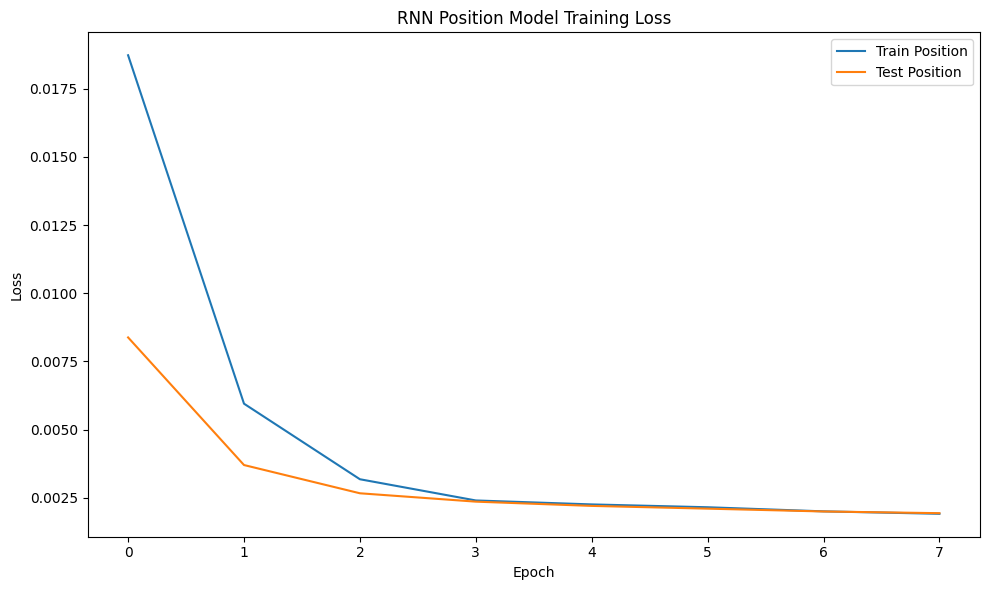

RNN model saved to .trained/rnn_2025-07-21_21-32-16.pt


In [91]:
RNN_EPOCHS = 8

# Train the RNN
rnn.train(epochs=RNN_EPOCHS)
rnn.plot_losses()
rnn.save()

In [9]:
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

del rnn

In [ ]:
from osu.gan import OsuReplayGAN

In [ ]:
print("Creating GAN model...")
gan = OsuReplayGAN(batch_size=BATCH_SIZE)
gan.load_data(xs, ys)

In [ ]:
GAN_EPOCHS = 4

# Train the GAN
for i in range(8):
    gan.train(epochs=GAN_EPOCHS)
    gan.save()
    
gan.plot_losses()

In [ ]:
from osu.keys import OsuKeyModel

In [ ]:
print("Creating keypress model...")
keys = OsuKeyModel(batch_size=BATCH_SIZE)
keys.load_data(xs, ys)

In [ ]:
KEYS_EPOCHS = 12

# Train the key model
for i in range(12):
    keys.train(epochs=KEYS_EPOCHS)
    keys.save()
    
keys.plot_losses()

In [ ]:
del keys

In [92]:
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'rally'
test_mods = Mods.HARD_ROCK
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


x         y  time_until_click  is_slider  is_spinner  \
chunk frame                                                                
0     0      0.283203  0.289062             0.450        0.0         0.0   
      1      0.283203  0.289062             0.426        0.0         0.0   
      2      0.283203  0.289062             0.402        0.0         0.0   
      3      0.283203  0.289062             0.378        0.0         0.0   
      4      0.283203  0.289062             0.354        0.0         0.0   
...               ...       ...               ...        ...         ...   
1     2043   0.000000  0.000000             0.000        0.0         0.0   
      2044   0.000000  0.000000             0.000        0.0         0.0   
      2045   0.000000  0.000000             0.000        0.0         0.0   
      2046   0.000000  0.000000             0.000        0.0         0.0   
      2047   0.000000  0.000000             0.000        0.0         0.0   

                cs  slider_speed  slider_len  
chunk frame                                   
0     0      0.442           0.0         0.0  
      1      0.442           0.0         0.0  
      2      0.442           0.0         0.0  
      3      0.442           0.0         0.0  
      4      0.442           0.0         0.0  
...            ...           ...         ...  
1     2043   0.000           0.0         0.0  
      2044   0.000           0.0         0.0  
      2045   0.000           0.0         0.0  
      2046   0.000           0.0         0.0  
      2047   0.000           0.0         0.0  

[4096 rows x 8 columns]

In [93]:
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

In [94]:
with torch.no_grad():
    # Use generator for inference
    replay_data = rnn.generate(data)
    
replay_data = np.concatenate(replay_data)
replay_data = np.pad(replay_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

print(f"Generated replay data shape: {replay_data.shape}")
print(f"Saved to .generated\\{test_name}.npy")

Generated replay data shape: (4096, 4)
Saved to .generated\rally.npy


In [95]:
data[:500]

tensor([[[ 0.2832,  0.2891,  0.4500,  ...,  0.4420,  0.0000,  0.0000],
         [ 0.2832,  0.2891,  0.4260,  ...,  0.4420,  0.0000,  0.0000],
         [ 0.2832,  0.2891,  0.4020,  ...,  0.4420,  0.0000,  0.0000],
         ...,
         [-0.2852,  0.1484,  0.0010,  ...,  0.4420,  0.4528,  0.1183],
         [-0.2676,  0.1406,  0.0000,  ...,  0.4420,  0.4528,  0.1183],
         [-0.2461,  0.1354,  0.0000,  ...,  0.4420,  0.4528,  0.1183]],

        [[-0.2266,  0.1302,  0.0000,  ...,  0.4420,  0.4528,  0.1183],
         [-0.2051,  0.1250,  0.0000,  ...,  0.4420,  0.4528,  0.1183],
         [-0.1855,  0.1198,  0.0000,  ...,  0.4420,  0.4528,  0.1183],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [96]:
replay_data[:500]

array([[ 0.09458502,  0.07263082,  0.        ,  0.        ],
       [ 0.12767291,  0.10748171,  0.        ,  0.        ],
       [ 0.15523073,  0.13469017,  0.        ,  0.        ],
       ...,
       [-0.12340993, -0.06278608,  0.        ,  0.        ],
       [-0.12643349, -0.0923314 ,  0.        ,  0.        ],
       [-0.10048315, -0.14435801,  0.        ,  0.        ]],
      dtype=float32)

In [97]:
import importlib
import osu.preview.preview as preview

importlib.reload(preview)

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)